In [1]:
#필요한 라이브러리 불러기기 및 텐서플로우 버전 확인
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(tf.__version__)

2.18.0


In [2]:
# GPU 사용 가능할 때만 돌리는 코드
# import os
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" #GPU 할당
# print(device_lib.list_local_devices()) #CPU, GPU 리스트 보는 법

In [3]:
#!nvidia-smi #GPU에 대한 내용 확인 시 사용하는 코드

In [4]:
# mnist data 불러와서 학습 및 테스트로 분할 
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# 불러온 데이터 중 NAN 값 있는지 확인
print(np.isnan(x_train).any())
print(np.isnan(y_train).any())
print(np.isnan(x_test).any())
print(np.isnan(y_test).any())

False
False
False
False


In [6]:
# 불러온 데이터를 학습하기 위해 
input_shape = (28, 28, 1)
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [7]:
# one-hot 인코딩을 사용해 라벨 값을 이진 벡터로 표현
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


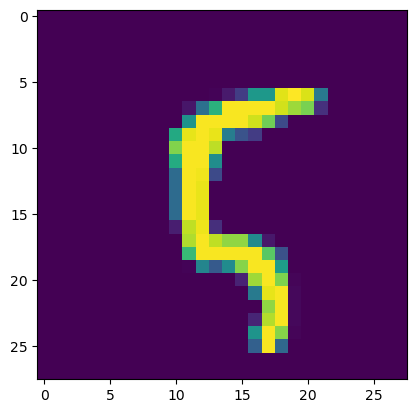

In [8]:
# 변환 후 결과확인 
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

In [9]:
# 모델 학습 파라미터 결정
##부분 값을 채우세요
batch_size = 20 ##
num_classes = 10 ##
epochs = 10 ##

In [10]:
# 모델 계계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

/opt/anaconda3/envs/embedded/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 모델의 call back 클래스 설정
#threshold 값을 채우세요.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>.975):
      print("\nReached (threshold)% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [12]:
#모델 학습
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/10
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 90s 33ms/step - acc: 0.8778 - loss: 0.3823 - val_acc: 0.9872 - val_loss: 0.0450
Epoch 2/10
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.9774 - loss: 0.0841
Reached (threshold)% accuracy so cancelling training!
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 96s 36ms/step - acc: 0.9774 - loss: 0.0841 - val_acc: 0.9908 - val_loss: 0.0405


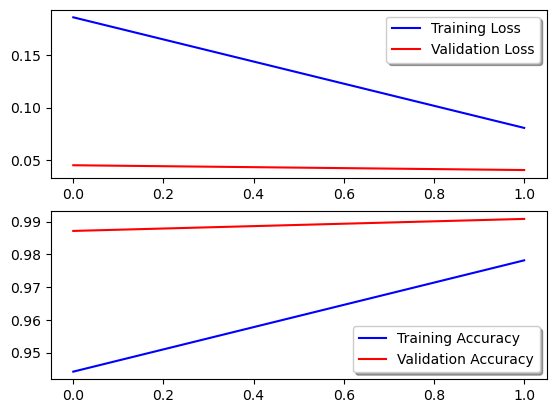

In [13]:
# 학습 결과 그래프로 표현
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("training_result.png")
plt.show()

In [14]:
# 테스트 데이터 셋을 통해 모델 성능 평가
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9874 - loss: 0.0392


In [15]:
# 테스트 데이터 셋으로 예측
Y_pred = model.predict(x_test)
# 예측 결과를 one-hot 인코딩으로 이진 벡터로 변환
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 정답 값을 one-hot 인코딩으로 이진 벡터로 변환
Y_true = np.argmax(y_test,axis = 1)
# 혼돈 매트릭스 계산
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


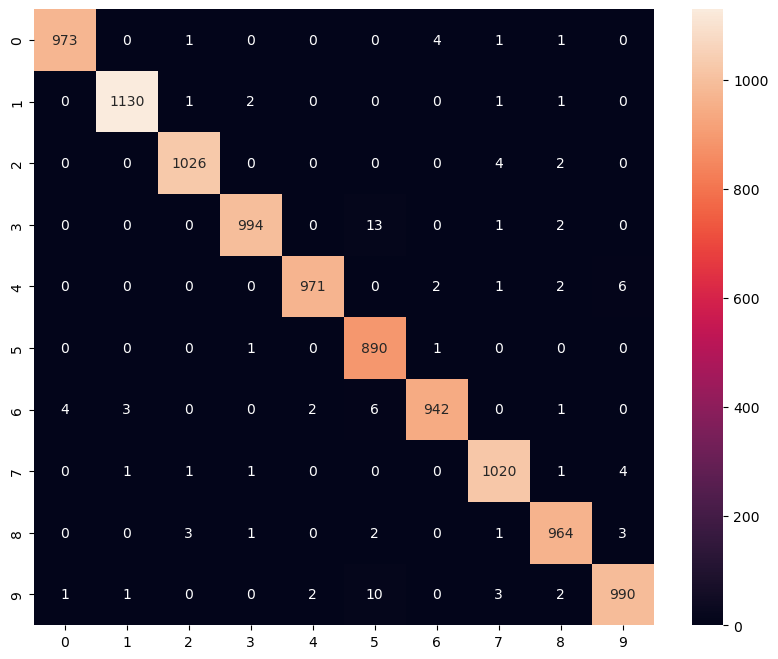

In [16]:
#혼돈 매트릭스 그래프로 그기기
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.savefig("confusion.png")

In [17]:
model.save("mnist_model.h5")